# Cointegration of residential REITs

## Statistical arbitrage by trading the residual

A mean reverting signal is one where a deviation from the mean will almost surely result in a movement back to the mean in the future. It is easy to see that this presents an arbitrage opportunity: The more the signal deviates from the mean, the greater your confidence that the trend will reverse. At a sufficient level of confidence, you take a position in the direction of reversal and exit the trade once the reversal completes.

## Basic cointegration

Let $\mathbf P_t\in \mathbb R^n\times \mathbb R_+$ be a vector of $n$ price series. $\mathbf P_t$ is said to be cointegrated if $\exists \mathbf\beta\in\mathbb R^n$ s.t.
$$
\langle\mathbf \beta,\mathbf P_t\rangle \sim I(0)
$$
at all times $t\in\mathbb R_+$. That is to say, the vector valued price series $\mathbf P_t$ is cointegrated if there is some linear combination of its constituents that is integrated to order 0. We assert that
$$
\mathbf \beta = (1,-\beta_2...,-\beta_n).
$$
With this normalization, the stationary inner product becomes
$$
\langle\mathbf \beta,\mathbf P_t\rangle  = p_{1,t}-\beta_2y_{2,t}-\cdots-\beta_np_{n,t}
$$
Let us call $\varepsilon_t:=\langle\mathbf \beta,\mathbf P_t\rangle$ the (mean-reverting) error series. Then,
$$
p_{1,t} = \beta_2p_{2,t}+\cdots+\beta_np_{n,t}+\varepsilon_t.
$$
If we take $\mathbf P_t$ to consist of two price series, the above expression simply tells you to regress one price series against the other and extract the residual. 



In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset,DataLoader

In [4]:
EQR = yf.Ticker("EQR").history(period='10y')
UDR = yf.Ticker("UDR").history(period='10y')
eqr_returns = np.log(1+EQR.Close.pct_change().dropna())
udr_returns = np.log(1+UDR.Close.pct_change().dropna())

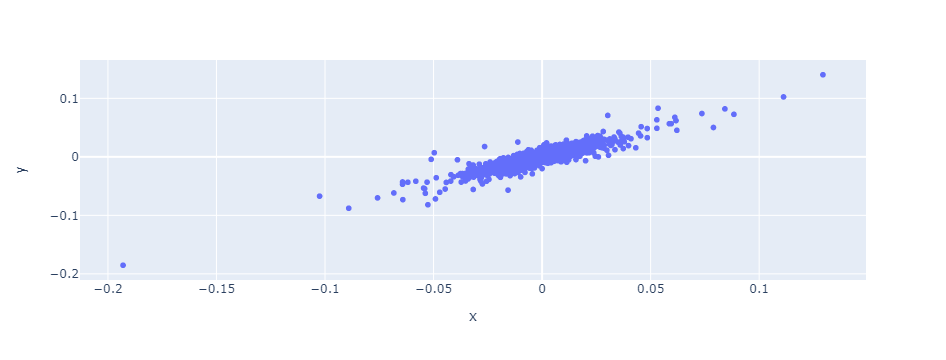

In [5]:
px.scatter(x=udr_returns, y=eqr_returns)

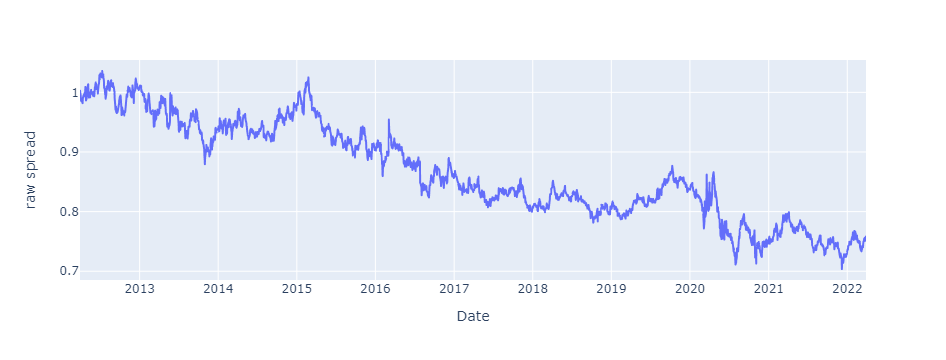

In [14]:
ret_spread = eqr_returns-udr_returns
raw_spread = np.exp(ret_spread.cumsum())
fig = px.line(raw_spread, labels={'date':'date','value':'raw spread'})
fig.update_layout(showlegend=False)

The spread is clearly drifting

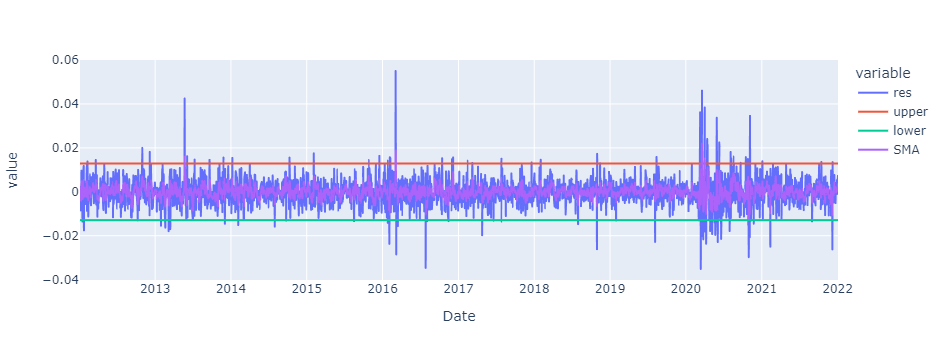

In [309]:
reg = LinearRegression().fit(eqr_returns.values.reshape(-1, 1), udr_returns.values.reshape(-1, 1))
res = reg.predict(eqr_returns.values.reshape(-1, 1))-udr_returns.values.reshape(-1, 1)
res_ts = pd.DataFrame(data=res, index=eqr_returns.index)
res_ts.columns = ["res"]
res_ts["upper"] = res_ts["res"].mean()+2*res_ts["res"].std()
res_ts["lower"] = res_ts["res"].mean()-2*res_ts["res"].std()
res_ts["SMA"] = res_ts["res"].ewm(span=5).mean()
px.line(res_ts)

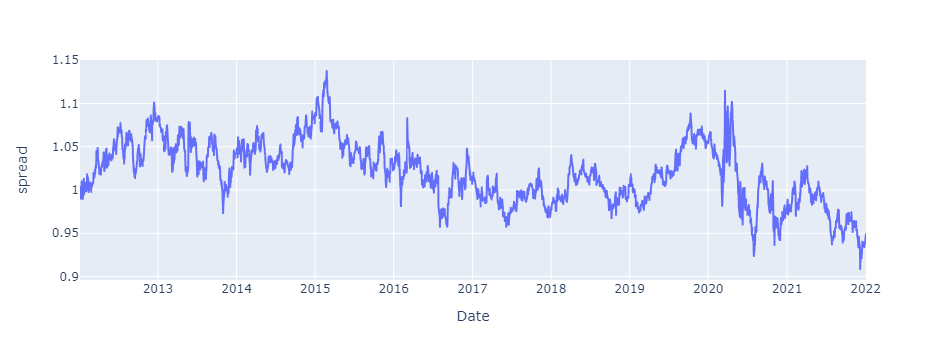

In [310]:
res_ts["spread"] = (res_ts["res"]+1).cumprod()
px.line(res_ts, x=res_ts.index, y=res_ts.spread)

In [311]:
def expanding_lin_reg(offset=10):
    res = []
    coefs = []
    for i in range(offset, len(eqr_returns)):
        reg = LinearRegression().fit(eqr_returns.values[:i].reshape(-1, 1), udr_returns.values[:i].reshape(-1, 1))
        coefs.append(reg.coef_[0][0])
        res.append(reg.predict(eqr_returns.values[:i].reshape(-1, 1))-udr_returns.values[:i].reshape(-1, 1))
    return res, coefs

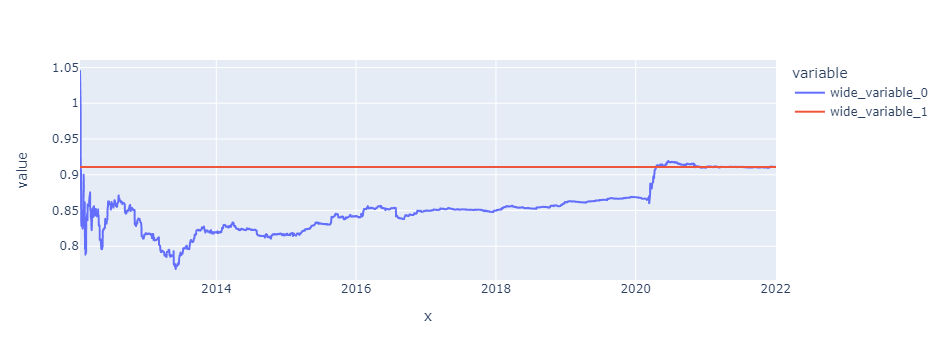

In [312]:
res, coefs = expanding_lin_reg()
px.line(x=eqr_returns.index[10:], y=[coefs, reg.coef_[0][0]*np.ones(len(eqr_returns.index[10:]))])

In [313]:
def windowed_sequence(data, tw, tensor=True, labels_only=False):
    if tensor:
        data = torch.FloatTensor(data).view(-1).to(torch.device("cuda:0"))
    else:
        pass
    window = []
    for i in range(len(data)-tw):
        seq = data[i:i+tw]
        label = data[i+tw:i+tw+1]
        if not labels_only:
            window.append((seq ,label))
        else:
            window.append(label[0])
    return window

In [332]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, output_size=1, hidden_layer_size=128):
        device = torch.device("cuda:0")
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_layer_size = hidden_layer_size
        super().__init__()
        self.lstm = nn.LSTM(self.input_size, self.hidden_layer_size, batch_first=False, device=device)
        self.linear = nn.Linear(self.hidden_layer_size, self.output_size, device=device)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size, device=device),
                            torch.zeros(1,1,self.hidden_layer_size, device=device))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]
model = LSTM(hidden_layer_size=32)
model.cuda()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [333]:
device = torch.device("cuda:0")
epochs = 10
window_size = 24
scaler =MinMaxScaler()
scaler.fit(res_ts.res.values.reshape(-1, 1))
train = scaler.transform(res_ts.res[:int(0.8*len(res_ts))].values.reshape(-1, 1))
test = scaler.transform(res_ts.res[int(0.8*len(res_ts)):].values.reshape(-1, 1))
for i in range(epochs):
    feature_label = windowed_sequence(train, window_size)
    for seq, labels in feature_label:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size, device=device),
                             torch.zeros(1, 1, model.hidden_layer_size, device=device))
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   0 loss: 0.00530319
epoch:   1 loss: 0.00173145
epoch:   2 loss: 0.00172798
epoch:   3 loss: 0.00172716
epoch:   4 loss: 0.00172680
epoch:   5 loss: 0.00172652
epoch:   6 loss: 0.00172626
epoch:   7 loss: 0.00172598
epoch:   8 loss: 0.00172570
epoch:   9 loss: 0.00172544
epoch:   9 loss: 0.0017254376


In [334]:
def predict(data_loader, model_):
    output = torch.tensor([], device=device)
    model_.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model_(X)
            output = torch.cat((output, y_star), 0)
    return output

In [337]:
forecast = pd.DataFrame(predict(windowed_sequence(test, window_size), model).cpu().numpy(), index=res_ts.index[window_size+int(0.8*len(res_ts)):], columns=["pred"] )
forecast["true"] = np.array(windowed_sequence(test, window_size, False, True)).flatten()
forecast["pred_ema"] = MinMaxScaler().fit_transform(forecast['pred'].ewm(5).mean().values.reshape(-1, 1))
forecast["true_ema"] = MinMaxScaler().fit_transform(forecast['true'].ewm(5).mean().values.reshape(-1, 1))


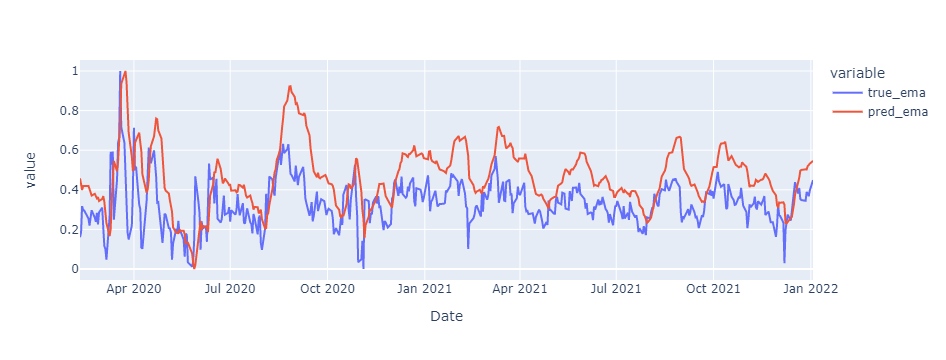

In [338]:
px.line(np.abs(forecast["true"] - forecast["pred"]))
px.line(forecast[["true_ema", "pred_ema"]])